In [8]:
import numpy as np
from scipy.linalg import expm, eig, norm
import matplotlib.pyplot as plt

In [9]:
# We define Pauli matices and a helper function for tensor products of Paulis for convenience to use later.
ident = np.array([[1, 0], [0, 1]])
pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])


def pauli_product(pauli_string):
    """Helper method to compute kronecker product of Paulis"""

    prod = 1
    for p in pauli_string:
        if p == "I":
            prod = np.kron(prod, ident)
        elif p == "X":
            prod = np.kron(prod, pauli_x)
        elif p == "Y":
            prod = np.kron(prod, pauli_y)
        elif p == "Z":
            prod = np.kron(prod, pauli_z)

    return prod

def sortES(eigVals, eigVecs):
    """
    simple routine to sort eigenvectors given the eigenvalues
    """

    # Zip the associated eigenvalues and eigenvectors together and sort by eigenvalue
    eigSystem = sorted(zip(eigVals, np.transpose(eigVecs)), key = lambda x: x[0])
    eigValsOut = [eVal for eVal, _ in eigSystem]
    eigVecsOut = [eVec for _, eVec in eigSystem]

    return eigValsOut,eigVecsOut

def printstate(v, L, cutoff):
    """
    routine to print quantum states in human readable format.
    cutoff value will skip entries with small amplitudes
    """
    for i in range(1<<L):
        # index, binary repr, amplitudes, amplitudes squared
        if v[i] * np.conj(v[i]) > cutoff:
            print(f"{i}  -  {np.binary_repr(i, width=L)}  -  {v[i]}  -  {v[i]*np.conj(v[i])}")

def diag_H(H):
    eigVals,eigVecs = eig(H)
    eigVals,eigVecs = sortES(eigVals, eigVecs)
    en_exact = eigVals[0]

    print("\nGround state energy exact")
    print(np.real(en_exact))

    print(f"\nGap (Delta): {np.real(eigVals[1] - eigVals[0])}")

## 1. L qubit Hamiltonain

- Generalize the 2-qubit case and devise a method to construct an arbitrary $L$-qubit transverse field Ising Hamiltonian $H = - J \sum_i Z_i Z_{i+1} - h \sum_i Z_i - \Gamma \sum_i X_i$
- What is the ground state energy of an 8-qubit Hamiltonian, with
    - $J = 1$
    - $\Gamma = 1$
    - keeping as the local magnetic field strenght $h = 0.1$, i.e., adding an additional term $h \sum_i Z_i$
    - periodic boudary conditions

In [10]:
def tfim_op_strings(L: int, pbc: bool):
    zz_ops = []
    z_ops = []
    x_ops = []

    for i in range(L - 1):
        zz_ops.append((L - 2 - i) * "I" + "ZZ" + i * "I")
        z_ops.append((L - 1 - i) * "I" + "Z" + i * "I")
        x_ops.append((L - 1 - i) * "I" + "X" + i * "I")

    z_ops.append("Z" + (L - 1) * "I")
    x_ops.append("X" + (L - 1) * "I")
    if pbc:
        zz_ops.append("Z" + (L - 2) * "I" + "Z")
    return zz_ops, z_ops, x_ops
    
def tfim_hamiltonian(L: int, J: float, gamma: float, mag: float, pbc: bool):
    zz_ops, z_ops, x_ops = tfim_op_strings(L, pbc)

    zz_terms, z_terms, x_terms = 0, 0, 0
    for zz in zz_ops:
        zz_terms += J * pauli_product(zz)
    for z in z_ops:
        z_terms += mag * pauli_product(z)
    for x in x_ops:
        x_terms += gamma * pauli_product(x)

    return zz_terms, z_terms, x_terms


In [11]:
# hardcoding number of sites
L = 8
J = 1
gamma = 1
mag = 0.1
pbc = True

zz_ops, z_ops, x_ops = tfim_op_strings(L, pbc)
print(zz_ops)
print(z_ops)
print(x_ops)

ZZ, Z, X = tfim_hamiltonian(L, J, gamma, mag, pbc)
H = - ZZ - Z - X
print(H)

['IIIIIIZZ', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IIZZIIII', 'IZZIIIII', 'ZZIIIIII', 'ZIIIIIIZ']
['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII']
['IIIIIIIX', 'IIIIIIXI', 'IIIIIXII', 'IIIIXIII', 'IIIXIIII', 'IIXIIIII', 'IXIIIIII', 'XIIIIIII']
[[-8.8 -1.  -1.  ...  0.   0.   0. ]
 [-1.  -4.6  0.  ...  0.   0.   0. ]
 [-1.   0.  -4.6 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... -3.4  0.  -1. ]
 [ 0.   0.   0.  ...  0.  -3.4 -1. ]
 [ 0.   0.   0.  ... -1.  -1.  -7.2]]


In [12]:
# diagonalize the hamiltonian

eigVals,eigVecs = eig(H)
eigVals,eigVecs = sortES(eigVals, eigVecs)
en_exact = eigVals[0]

print("\nGround state energy exact")
print(np.real(en_exact))

print(f"\nGap (Delta): {np.real(eigVals[1] - eigVals[0])}")



Ground state energy exact
-10.806456545769649

Gap (Delta): 1.2233351071393397


## 2. Time to solution (TTS)

- Define an Ising model with
    - $L = 8
    - $J = 1$
    - $\Gamma = 1$
    - keeping as the local magnetic field strenght $h = 0.1$, i.e., adding an additional term $h \sum_i Z_i$
    - periodic boudary conditions
- Compute the exact ground state of $H_P = - J \sum_i Z_i Z_{i+1} - h \sum_i Z_i$
- Compute the ground state of $H_P$ via quantum annealing for a range of annealing times $t_{\rm total} \in \{ 1, 1.1, \ldots, 10 \}$ with increments of 0.1 and a step size of $\Delta t = 0.1$
- Compute the success probability $p_\mathrm{success}$ at the end of the anneal
- Compute the time to solution (TTS) of each anneal as a function of $t_\mathrm{total}$
- Plot both $p_\mathrm{success}$ and TTS

In [16]:
J = 1
gamma = 1
mag = 0.1
pbc = True

L = 8

ZZ, Z, X = tfim_hamiltonian(L, J, gamma, mag, pbc)
H_P = - ZZ - Z
H_Q = - X

eigVals, eigVecs = eig(H_P)
eigVals, eigVecs = sortES(eigVals, eigVecs)
exact_sol = eigVecs[0]

print("\nExact ground state energy of H_P")
print(np.real(eigVals[0]))

print("\nExact ground state wf of H_P")
printstate(eigVecs[0], L, 0.001)

init_psi = np.ones(1<<L, dtype=complex)
init_psi /= norm(init_psi, 2)

t_tot_list = np.arange(1, 15.1, 0.1)
# t_tot_list = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 50, 100]
dt = 0.1

succ_prob = []
tts = []
for t_tot in t_tot_list:
    Nt = int(t_tot / dt)
    t_array = np.linspace(0, t_tot, num=Nt + 1)
    print(f"\nt_tot = {t_tot}, Nt = {Nt}")

    psi = init_psi
    for t in t_array:
        s = t / t_tot
        H_instant = (1.0 - s) * H_Q + s * H_P
        psi = expm(-1.j * dt * H_instant).dot(psi)

    overlap = np.conj(exact_sol).dot(psi)
    succ_prob.append(overlap.real**2 + overlap.imag**2)
    tts.append(t_tot * np.log(1 - 0.99) / np.log(1 - succ_prob[-1]))
    print(f"p_success = {succ_prob[-1]}  -  TTS = {tts[-1]}")


Exact ground state energy of H_P
-8.8

Exact ground state wf of H_P
0  -  00000000  -  1.0  -  1.0

t_tot = 1.0, Nt = 10
p_success = 0.021367410744115814  -  TTS = 213.21220655438577

t_tot = 1.1, Nt = 11
p_success = 0.026318537813197315  -  TTS = 189.9319097657877

t_tot = 1.2000000000000002, Nt = 12
p_success = 0.03201770630928881  -  TTS = 169.82029171142443

t_tot = 1.3000000000000003, Nt = 13
p_success = 0.03843016080316768  -  TTS = 152.76893129447498

t_tot = 1.4000000000000004, Nt = 14
p_success = 0.045491791113223864  -  TTS = 138.47448018021487

t_tot = 1.5000000000000004, Nt = 15
p_success = 0.053115377360920535  -  TTS = 126.56659750806855

t_tot = 1.6000000000000005, Nt = 16
p_success = 0.061199325108663404  -  TTS = 116.67502348266109

t_tot = 1.7000000000000006, Nt = 17
p_success = 0.06963734658335516  -  TTS = 108.46079930474495

t_tot = 1.8000000000000007, Nt = 18
p_success = 0.07832747744667082  -  TTS = 101.62785304015027

t_tot = 1.9000000000000008, Nt = 19
p_succe

In [17]:
min_tts_idx = np.argmin(tts)

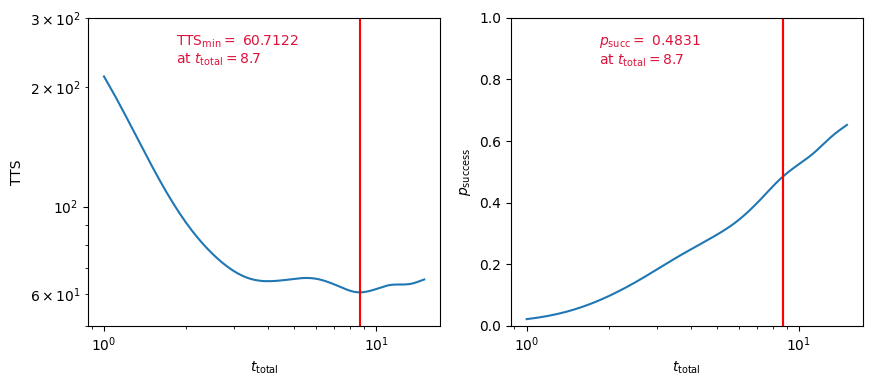

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axs[0].plot(t_tot_list, tts)
axs[0].set_xlabel(rf"$t_{{\rm total}}$")
axs[0].set_ylabel(rf"TTS")
axs[0].set_ylim(5e1, 3e2)
axs[0].loglog()

axs[0].plot([t_tot_list[min_tts_idx], t_tot_list[min_tts_idx]], [-1e4, 1e6], color="red")
axs[0].text(
    0.25, 0.95,
    rf"${{\rm TTS}}_{{\rm min}} =$ {tts[min_tts_idx]:.4f}" + "\n" + rf"at $t_{{\rm total}}=${t_tot_list[min_tts_idx]:.1f}",
    color="crimson",
    transform=axs[0].transAxes,
    # fontsize=,
    verticalalignment='top'
)


axs[1].plot(t_tot_list, succ_prob)
axs[1].set_xlabel(rf"$t_{{\rm total}}$")
axs[1].set_ylabel(rf"$p_{{\rm success}}$")
axs[1].plot([t_tot_list[min_tts_idx], t_tot_list[min_tts_idx]], [-1e4, 1e6], color="red")
axs[1].set_ylim(0.0, 1)

axs[1].plot([t_tot_list[min_tts_idx], t_tot_list[min_tts_idx]], [0, 2], color="red")
axs[1].text(
    0.25, 0.95,
    rf"${{p}}_{{\rm succ}} =$ {succ_prob[min_tts_idx]:.4f}" + "\n" + rf"at $t_{{\rm total}}=${t_tot_list[min_tts_idx]:.1f}",
    color="crimson",
    transform=axs[1].transAxes,
    # fontsize=,
    verticalalignment='top'
)

plt.show()